<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Text_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

# Mount your Google Drive to the local /content/drive directory
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from os import listdir, path

local_folder = "/content/drive/My Drive/"

with open(path.join(local_folder ,"dataset/shakespeare.txt")) as f:
  shakespeare_dataset = f.read()

## Cleaning the dataset and spliting into training examples and lables

In [5]:
shakespeare_dataset = shakespeare_dataset.split('\n\n')
shakespeare_dataset = shakespeare_dataset[2:-1]

In [6]:
sos_token = "<SOS>"
eos_token = "<EOS>"
space = " "

dataset = [[sos_token + space + document ] for document in shakespeare_dataset if document != ""]
labels = [[document + space + eos_token] for document in shakespeare_dataset if document != ""]

number_documents = len(dataset)
print(number_documents)

141


In [7]:
max_doc_length = 0

for doc in dataset:
  if len(doc[0].split()) > max_doc_length:

    max_doc_length = len(doc[0].split())

print(max_doc_length)

238


## Split dataset into a training an validation set

In [23]:
training_percentage = 80

training_samples = (number_documents * training_percentage) // 100
validation_samples = number_documents - training_samples

X_train = dataset[:training_samples]
Y_train = labels[:training_samples]

X_val = dataset[training_samples:]
Y_val = labels[training_samples:]

## Text Vectorization

In [24]:
from tensorflow.keras import layers
text_vectorization = layers.TextVectorization(
    standardize='lower',
    split='whitespace',
    output_mode='int'
)

In [25]:
text_vectorization.adapt(dataset)

In [26]:
dataset = text_vectorization(dataset)
vocabulary_size = text_vectorization.vocabulary_size()
vocabulary = text_vectorization.get_vocabulary()

In [27]:
# Dictionay to map back from integer index to word
from_int_to_word ={}
from_word_to_int = {}

for idx,word in enumerate(vocabulary):
    from_int_to_word[idx] = word
    from_word_to_int[word] = idx

In [28]:
labels = text_vectorization(labels)

In [29]:
X_train = text_vectorization(X_train)
Y_train = text_vectorization(Y_train)
X_val = text_vectorization(X_val)
Y_val = text_vectorization(Y_val)

## Creation of a tensorflow dataset using training examples and labels

In [30]:
from tensorflow.data import Dataset
# Creation of the datasets to feed to the model
train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
)

val_dataset = Dataset.from_tensor_slices(
    (X_val, Y_val)
)

# shuffle and split into batches of batch size BATCH_SIZE
BATCH_SIZE = 64

# Buffer size of the buffer to shuffle the dataset
# Otherfwise TF will have the full dataset in memory
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Creation

In [46]:
word_embedding_vector_dimension = 16

word_embedding = layers.Embedding(
    input_dim = vocabulary_size,
    output_dim=word_embedding_vector_dimension
)

In [47]:
lstm_layer_1 = layers.LSTM(128, input_shape = (1 ,number_documents, word_embedding_vector_dimension), return_sequences = True)
lstm_layer_2 = layers.LSTM(128, return_sequences = True)

In [48]:
from tensorflow.keras.activations import softmax
softmax_layer = layers.Dense(units=vocabulary_size, activation=softmax)

In [49]:
from tensorflow.keras import Sequential

steps = [word_embedding, lstm_layer_1, lstm_layer_2, softmax_layer]
model = Sequential(steps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          68720     
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 dense_1 (Dense)             (None, None, 4295)        554055    
                                                                 
Total params: 828599 (3.16 MB)
Trainable params: 828599 (3.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss = SparseCategoricalCrossentropy(from_logits=True)

In [51]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=1e-3)

In [52]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
metric = SparseCategoricalAccuracy()

In [53]:
model.compile(optimizer = adam_optimizer, loss = loss, metrics=[metric])

## Testing the model works

In [54]:
first_batch = train_dataset.take(1)

In [55]:
for input_data, labels in first_batch:
  predictions = model(input_data)
  assert predictions.shape == (BATCH_SIZE, max_doc_length, vocabulary_size)

## Configuring checkpoints

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [61]:
checkpoint_folder = path.join(local_folder,
                              "tf_checkpoints/Text Generation using RNN"
)

checkpoint_files_path = path.join(checkpoint_folder, "ckpt_{epoch}")

EPOCHS = 10
SAVING_FREQUENCY = 100

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_files_path,
    save_weights_only=True,
    #save_freq="epoch",
    #period=SAVING_FREQUENCY

)

## Training

In [62]:
restart = False
restart_epoch = 1000

if restart:
  checkpoint_files_path = path.join(checkpoint_folder, f"ckpt_{restart_epoch}")
  model.load_weights(checkpoint_files_path)

history = model.fit(train_dataset,
                    validation_data=val_dataset ,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/10
2/2 [==============================] - 6s 3s/step - loss: 4.3119 - sparse_categorical_accuracy: 0.4621 - val_loss: 7.3230 - val_sparse_categorical_accuracy: 0.0665
Epoch 2/10
2/2 [==============================] - 9s 3s/step - loss: 4.3000 - sparse_categorical_accuracy: 0.4621 - val_loss: 7.2809 - val_sparse_categorical_accuracy: 0.0665
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 4.2921 - sparse_categorical_accuracy: 0.4621 - val_loss: 7.2473 - val_sparse_categorical_accuracy: 0.0665
Epoch 4/10
2/2 [==============================] - 8s 3s/step - loss: 4.2893 - sparse_categorical_accuracy: 0.4621 - val_loss: 7.2236 - val_sparse_categorical_accuracy: 0.0665
Epoch 5/10
2/2 [==============================] - 6s 3s/step - loss: 4.2883 - sparse_categorical_accuracy: 0.4621 - val_loss: 7.2107 - val_sparse_categorical_accuracy: 0.0665
Epoch 6/10
2/2 [==============================] - 9s 3s/step - loss: 4.2888 - sparse_categorical_accuracy: 0.4621 - val_loss:

## Plotting Validation and training Loss

In [64]:
import pandas as pd
results = pd.DataFrame.from_dict(history.history)

<Axes: >

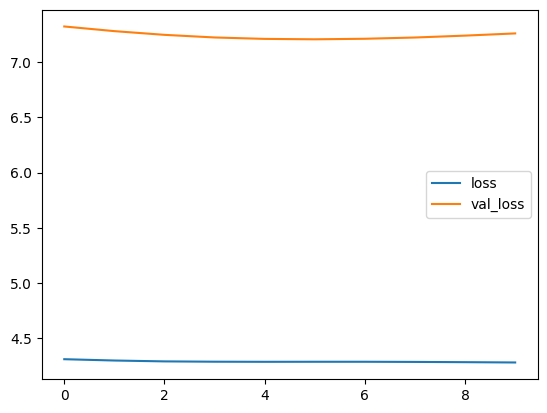

In [68]:
results.plot(y=['loss', 'val_loss'], use_index=True)